In [1]:
import geopandas
import matplotlib.pyplot as mp
import cartopy
import numpy
import xarray
import cmocean
#import rasterio
import shapely

In [32]:
ca_eco_l3_gs = geopandas.GeoSeries.from_file('../../ca_eco_l3/ca_eco_l3.shp')
ca_eco_l3_gs = geopandas.GeoSeries.from_file('../../ca_eco_l3/ca_eco_l3.shp')

In [33]:
ca_eco_l3_gs.crs

{'init': 'epsg:5070'}

In [10]:
sierras_series = ca_eco_l3_gs.loc[4]

In [11]:
states_shapes = cartopy.io.shapereader.natural_earth(resolution='10m', category='cultural', name='admin_1_states_provinces')
shapes_reader = cartopy.io.shapereader.Reader(states_shapes)

states_name_list = numpy.array(([i.attributes['name'] for i in shapes_reader.records()]))
for i in shapes_reader.records():
    if i.attributes['name']=='California' and i.attributes['iso_a2']=='US':
        CA_object = i
CA_object_no_islands = CA_object.geometry.geoms[-1] # get the last one (the state of Cali)


In [12]:
lon_lo, lon_hi, lat_lo, lat_hi = 235.25, 246.25, 32., 42.5

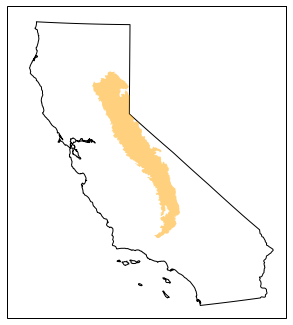

In [34]:
fig = mp.figure(figsize=(5,10))

map_proj = cartopy.crs.LambertConformal(standard_parallels=[lat_lo,lat_hi], \
    central_longitude=0.5*(lon_lo+lon_hi), \
    central_latitude=0.5*(lat_lo+lat_hi))

ecoregions_proj = cartopy.crs.AlbersEqualArea(central_longitude=-96.0, \
                            central_latitude=23.0, \
                            false_easting=0.0, \
                            false_northing=0.0, \
                            standard_parallels=(29.5, 45.5), \
                            globe=None)
#ecoregions_proj = cartopy.crs.epsg(ca_eco_l3_gs.crs['init'].split(':')[1])

ax = fig.add_subplot(111, projection=map_proj)
#ax.coastlines(resolution='50m')
ax.set_extent([lon_lo, lon_hi, lat_lo, lat_hi])

ax.add_geometries(CA_object.geometry, crs=cartopy.crs.PlateCarree(), facecolor='None', edgecolor='0')

ax.add_geometries([sierras_series], crs=ecoregions_proj, facecolor='orange', alpha=0.5)

# vmin, vmax = -100., 4000.
# state_paths = cartopy.mpl.patch.geos_to_path(CA_object.geometry)
# for i in range(len(state_paths)):
#     topo_image = ax.pcolormesh(topo_lon, topo_lat, topo_data, vmin=vmin, vmax=vmax, cmap=cmocean.cm.gray, transform=cartopy.crs.PlateCarree())
#     topo_image.set_clip_path(state_paths[i], transform=cartopy.crs.PlateCarree()._as_mpl_transform(ax))

# states_provinces = cartopy.feature.NaturalEarthFeature(
# category='cultural',
# name='admin_1_states_provinces_lines',
# scale='10m',
# facecolor='none')

# countries = cartopy.feature.NaturalEarthFeature(
# category='cultural',
# name='admin_0_countries',
# scale='10m',
# facecolor='none')

#ax.add_feature(states_provinces, edgecolor='0')
#ax.add_feature(countries, edgecolor='0')

#fig.savefig('topo_and_sierras_ecoregion.png', dpi=600, bbox_inches='tight', transparent=True)

open NetCDF4 CESM LENS data set

In [36]:
ncfile = xarray.open_dataset('/glade/collections/cdg/data/cesmLE/CESM-CAM5-BGC-LE/atm/proc/tseries/monthly/PRECC/b.e11.B1850C5CN.f09_g16.005.cam.h0.PRECC.040001-049912.nc')
prect_data = ncfile['PRECC'].sel(lat=slice(lat_lo-5,lat_hi+5),lon=slice(lon_lo-5,lon_hi+5)).values
prect_lat = ncfile['lat'].sel(lat=slice(lat_lo-5,lat_hi+5)).values
prect_lon = ncfile['lon'].sel(lon=slice(lon_lo-5,lon_hi+5)).values

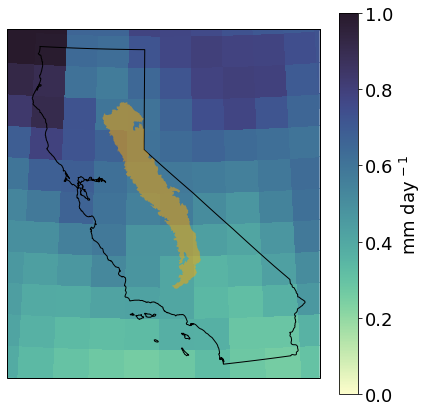

In [52]:
fig = mp.figure(figsize=(7,7))

map_proj = cartopy.crs.LambertConformal(standard_parallels=[lat_lo,lat_hi], \
    central_longitude=0.5*(lon_lo+lon_hi), \
    central_latitude=0.5*(lat_lo+lat_hi))

ecoregions_proj = cartopy.crs.AlbersEqualArea(central_longitude=-96.0, \
                            central_latitude=23.0, \
                            false_easting=0.0, \
                            false_northing=0.0, \
                            standard_parallels=(29.5, 45.5), \
                            globe=None)
#ecoregions_proj = cartopy.crs.epsg(ca_eco_l3_gs.crs['init'].split(':')[1])

lens_proj = cartopy.crs.PlateCarree()

ax = fig.add_subplot(111, projection=map_proj)
ax.set_extent([lon_lo, lon_hi, lat_lo, lat_hi])

ax.add_geometries(CA_object.geometry, crs=cartopy.crs.PlateCarree(), facecolor='None', edgecolor='0')
ax.add_geometries([sierras_series], crs=ecoregions_proj, facecolor='orange', alpha=0.5)

lon_pcolormesh = numpy.zeros(prect_lon.size+2)
lon_pcolormesh[1:-1] = prect_lon
lon_pcolormesh[0] = prect_lon[0]-numpy.diff(prect_lon)[0]
lon_pcolormesh[-1] = prect_lon[-1]+numpy.diff(prect_lon)[-1]
lon_pcolormesh_midpoints = lon_pcolormesh[:-1]+0.5*(numpy.diff(lon_pcolormesh))

lat_pcolormesh = numpy.zeros(prect_lat.size+2)
lat_pcolormesh[1:-1] = prect_lat
lat_pcolormesh[0] = prect_lat[0]-numpy.diff(prect_lat)[0]
lat_pcolormesh[-1] = prect_lat[-1]+numpy.diff(prect_lat)[-1]
lat_pcolormesh_midpoints = lat_pcolormesh[:-1]+0.5*(numpy.diff(lat_pcolormesh))

temps = ax.pcolormesh(lon_pcolormesh_midpoinprect,lat_pcolormesh_midpoinprect,prect_data.mean(axis=0)*1000.*86400.,\
                      cmap=cmocean.cm.deep,transform=lens_proj, vmin=0, vmax=1)
cbar = mp.colorbar(temps)
cbar.ax.tick_params(labelsize=18)
cbar.set_label('mm day$^{\,-1}$', fontsize=18)
#fig.savefig('topo_and_sierras_ecoregion.png', dpi=600, bbox_inches='tight', transparent=True)

Create polygon objects from lat/lon values  
Then calculate overlap

In [53]:
prect_data_masked = prect_data.mean(axis=0)

lat_indices=[7,\
             8,8,\
             9,9,\
             10,10,\
             11,11,11,\
             12,12,\
             13,13]
lon_indices=[8,\
             8,9,\
             8,9,\
             7,8,\
             6,7,8,\
             6,7,\
             6,7]

lat_polygon_hi_list = []
lon_polygon_hi_list = []
lat_polygon_lo_list = []
lon_polygon_lo_list = []

lon_list = []
lat_list = []

for i in range(lat_indices.__len__()):
    lat_idx = lat_indices[i]
    lon_idx = lon_indices[i]
    
    lon_list.append(prect_lon[lon_indices[i]])
    lat_list.append(prect_lat[lat_indices[i]])

    lon_polygon_hi_list.append(-360.+lon_pcolormesh_midpoints[lon_idx+1])
    lon_polygon_lo_list.append(-360.+lon_pcolormesh_midpoints[lon_idx])

    lat_polygon_hi_list.append(lat_pcolormesh_midpoints[lat_idx+1])
    lat_polygon_lo_list.append(lat_pcolormesh_midpoints[lat_idx])

In [54]:
lonlat_list = [i for i in zip(lon_list, lat_list)]

In [54]:
lonlat_list = numpy.load('lonlat_list_sierras.npy')
for i in lonlat_list:
    print(i[0],i[1])

241.25 34.3979057591623
241.25 35.340314136125656
242.5 35.340314136125656
241.25 36.282722513089
242.5 36.282722513089
240.0 37.225130890052355
241.25 37.225130890052355
238.75 38.16753926701571
240.0 38.16753926701571
241.25 38.16753926701571
238.75 39.10994764397907
240.0 39.10994764397907
238.75 40.0523560209424
240.0 40.0523560209424


In [18]:
# polygon_box = shapely.geometry.Polygon([[lon_polygon_lo, lat_polygon_lo], [lon_polygon_hi, lat_polygon_lo], \
#                                         [lon_polygon_hi, lat_polygon_hi], [lon_polygon_lo, lat_polygon_hi]])

#polygon_box = shapely.geometry.box(lon_polygon_lo,lat_polygon_lo,lon_polygon_hi,lat_polygon_hi)

polygon_boxes = [shapely.geometry.box(i[0],i[1],i[2],i[3]) for i in zip(lon_polygon_lo_list,lat_polygon_lo_list,\
                                                      lon_polygon_hi_list,lat_polygon_hi_list)]

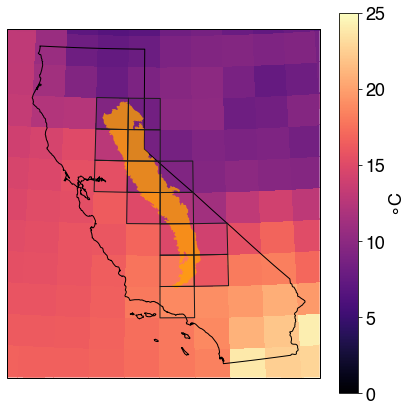

In [21]:
fig = mp.figure(figsize=(7,7))

map_proj = cartopy.crs.LambertConformal(standard_parallels=[lat_lo,lat_hi], \
    central_longitude=0.5*(lon_lo+lon_hi), \
    central_latitude=0.5*(lat_lo+lat_hi))

# data_proj = cartopy.crs.AlbersEqualArea(central_longitude=-96.0, \
#                             central_latitude=23.0, \
#                             false_easting=0.0, \
#                             false_northing=0.0, \
#                             standard_parallels=(29.5, 45.5), \
#                             globe=None)

ecoregions_proj = cartopy.crs.epsg(ca_eco_l3_gs.crs['init'].split(':')[1])

lens_proj = cartopy.crs.PlateCarree()

ax = fig.add_subplot(111, projection=map_proj)
ax.set_extent([lon_lo, lon_hi, lat_lo, lat_hi])

ax.add_geometries(CA_object.geometry, crs=cartopy.crs.PlateCarree(), facecolor='None', edgecolor='0')
ax.add_geometries([sierras_series], crs=ecoregions_proj, facecolor='orange', alpha=0.75)

lon_pcolormesh = numpy.zeros(ts_lon.size+2)
lon_pcolormesh[1:-1] = ts_lon
lon_pcolormesh[0] = ts_lon[0]-numpy.diff(ts_lon)[0]
lon_pcolormesh[-1] = ts_lon[-1]+numpy.diff(ts_lon)[-1]
lon_pcolormesh_midpoints = lon_pcolormesh[:-1]+0.5*(numpy.diff(lon_pcolormesh))

lat_pcolormesh = numpy.zeros(ts_lat.size+2)
lat_pcolormesh[1:-1] = ts_lat
lat_pcolormesh[0] = ts_lat[0]-numpy.diff(ts_lat)[0]
lat_pcolormesh[-1] = ts_lat[-1]+numpy.diff(ts_lat)[-1]
lat_pcolormesh_midpoints = lat_pcolormesh[:-1]+0.5*(numpy.diff(lat_pcolormesh))

temps = ax.pcolormesh(lon_pcolormesh_midpoints,lat_pcolormesh_midpoints,ts_data_masked-273.15,\
                      cmap='magma',transform=lens_proj, vmin=0, vmax=25)
cbar = mp.colorbar(temps)
cbar.ax.tick_params(labelsize=18)
cbar.set_label('$\circ$C', fontsize=18)

ax.add_geometries(polygon_boxes, crs=cartopy.crs.PlateCarree(), facecolor='None', edgecolor='0.1')

fig.savefig('topo_and_sierras_ecoregion_with_polyboxes.png', dpi=600, bbox_inches='tight', transparent=True)

In [ ]:
ca_eco_l3_alt = geopandas.GeoSeries.from_file('../ca_eco_l3/ca_eco_l3.shp')
ca_eco_l3_alt[4]

ca_eco_l3_alt.crs = example_for_crs.crs

#sierras_series_alt = ca_eco_l3[4]

In [22]:
ca_eco_l3_gs_4326 = ca_eco_l3_gs.to_crs({'init': 'epsg:4326'})

In [24]:
sierras_series_geom_4326 = ca_eco_l3_gs_4326.loc[4]

In [25]:
type(sierras_series_geom_4326)

shapely.geometry.polygon.Polygon

# calculates percent area overlap

In [43]:
for box in polygon_boxes:
    print('{:.2f}'.format(sierras_series_geom_4326.intersection(box).area/box.area))

0.01
0.33
0.07
0.52
0.07
0.21
0.67
0.03
0.84
0.14
0.35
0.56
0.51
0.24


# create mask of NaNs and fractional values

In [56]:
mask_and_weights = numpy.zeros(ts_data_masked.shape)
mask_and_weights[~numpy.isnan(ts_data_masked)]=numpy.nan

In [58]:
for i,latlon in enumerate(zip(lat_indices,lon_indices)):
    mask_and_weights[latlon[0],latlon[1]] = sierras_series_geom_4326.intersection(polygon_boxes[i]).area/polygon_boxes[i].area

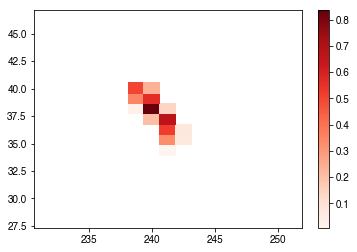

In [60]:
mask_plot = mp.pcolormesh(lon_pcolormesh_midpoints,lat_pcolormesh_midpoints,mask_and_weights,cmap='Reds')
mp.colorbar(mask_plot)